# Task-1: Training an autoencoder as a 2D feature generator and displaying CIFAR10 dataset's features.

# Importing necessary libraries

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose, GlobalAveragePooling2D

# Load and preprocess the CIFAR-10 dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Building the autoencoder model

In [ ]:
LATENT_DIM = 2

input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 4x4

shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten()(x)
latent_vector = Dense(LATENT_DIM, name='latent_space')(x)

encoder = Model(input_img, latent_vector, name='encoder')
encoder.summary()

latent_input = Input(shape=(LATENT_DIM,))

x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_input)
x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 16x16
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 32x32

decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_input, decoded_output, name='decoder')
decoder.summary()

autoencoder_input = Input(shape=(32, 32, 3), name='autoencoder_input')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

I0000 00:00:1752077202.470474 1662046 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        97,346 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       246,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,197 (1.31 MB)

 Trainable params: 344,197 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and train the autoencoder

Epoch 1/25


I0000 00:00:1752049136.249235 1131889 service.cc:152] XLA service 0x27becb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752049136.249252 1131889 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-09 14:18:56.276198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752049136.429947 1131889 cuda_dnn.cc:529] Loaded cuDNN version 90300


 70/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0617

I0000 00:00:1752049138.308027 1131889 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0477 - val_loss: 0.0371
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0370 - val_loss: 0.0368
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0369 - val_loss: 0.0367
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366 - val_loss: 0.0366
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366 - val_loss: 0.0365
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0366 - val_loss: 0.0365
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364 - val_loss: 0.0365
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0363 - val_loss: 0.0365
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0363 - val_loss: 0.0364
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0363 - val_loss: 0.0364
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0363 - val_loss: 0.0363
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

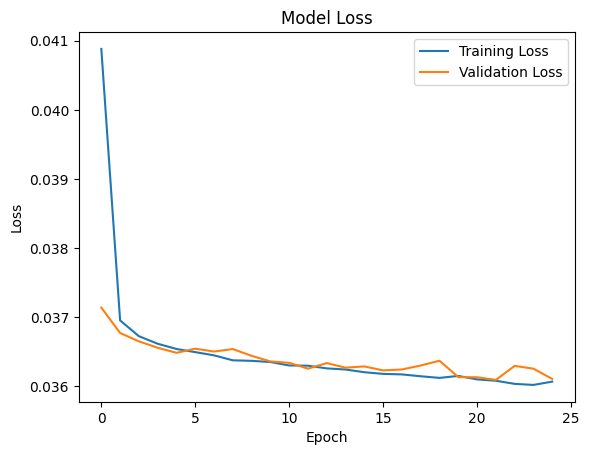

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualizing reconstructed images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


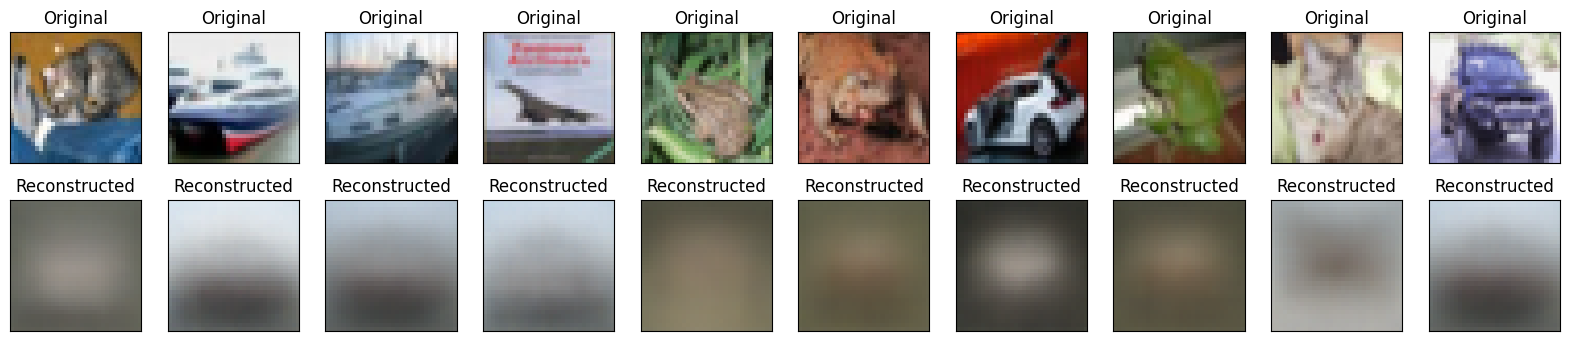

In [ ]:
reconstructed_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i])
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generating and displaying the 2D features

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step


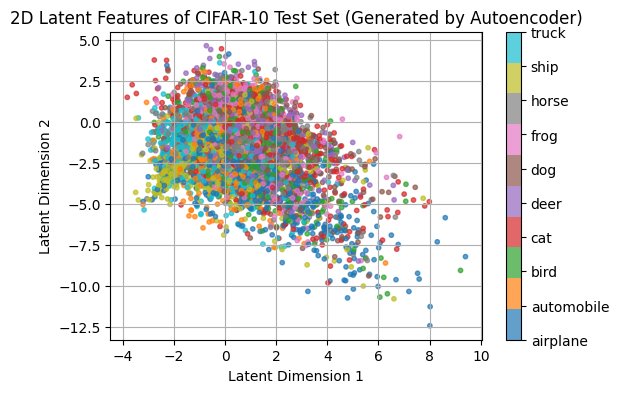

In [ ]:
latent_features = encoder.predict(x_test)

plt.figure(figsize=(6, 4))
scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')

cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
plt.title('2D Latent Features of CIFAR-10 Test Set (Generated by Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

# Task-2: Comparing autoencoder generated features with features extracted by a pre-trained CNN and reduced by dimension reduction techniques like PCA, t-SNE.

# Load VGG-16 and extract high-dimensional features

In [ ]:
vgg16_base = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

print("Setting layer trainability...")
for i, layer in enumerate(vgg16_base.layers):
    if i < len(vgg16_base.layers) - 10:
        layer.trainable = False
    else:
        layer.trainable = True
    print(f"Layer {layer.name}: Trainable = {layer.trainable}")

vgg16_base.summary()

Setting layer trainability...
Layer input_layer_2: Trainable = False
Layer block1_conv1: Trainable = False
Layer block1_conv2: Trainable = False
Layer block1_pool: Trainable = False
Layer block2_conv1: Trainable = False
Layer block2_conv2: Trainable = False
Layer block2_pool: Trainable = False
Layer block3_conv1: Trainable = False
Layer block3_conv2: Trainable = False
Layer block3_conv3: Trainable = True
Layer block3_pool: Trainable = True
Layer block4_conv1: Trainable = True
Layer block4_conv2: Trainable = True
Layer block4_conv3: Trainable = True
Layer block4_pool: Trainable = True
Layer block5_conv1: Trainable = True
Layer block5_conv2: Trainable = True
Layer block5_conv3: Trainable = True
Layer block5_pool: Trainable = True


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

# Create and Fine-Tune the Model on CIFAR-10

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = vgg16_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10)(x)
fine_tune_model = tf.keras.Model(inputs, outputs)

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_model.summary()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_test_flat = y_test.flatten()

print("\nStarting fine-tuning...")
history_finetune = fine_tune_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 13,574,410 (51.78 MB)

 Non-trainable params: 1,145,408 (4.37 MB)


Starting fine-tuning...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5257 - loss: 1.3424 - val_accuracy: 0.7332 - val_loss: 0.7754
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7566 - loss: 0.6951 - val_accuracy: 0.7610 - val_loss: 0.6937
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7940 - loss: 0.5938 - val_accuracy: 0.7807 - val_loss: 0.6379
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8267 - loss: 0.5001 - val_accuracy: 0.7860 - val_loss: 0.6311
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8492 - loss: 0.4349 - val_accuracy: 0.7745 - val_loss: 0.6622
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8734 - loss: 0.3685 - val_accuracy: 0.8028 - val_loss: 0.5771
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8916 - loss: 0.3151 - val_accuracy: 0.7936 - val_loss: 0.6432
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9074 - loss

# Apply PCA and t-SNE for Dimensionality Reduction

In [ ]:
tuned_vgg_layer = fine_tune_model.get_layer('vgg16')

print("Extracting fine-tuned features using the updated layer...")
vgg_features_tuned = tuned_vgg_layer.predict(x_test)

vgg_features_tuned_flat = vgg_features_tuned.reshape(vgg_features_tuned.shape[0], -1)
print("Shape of fine-tuned features:", vgg_features_tuned_flat.shape)

print("\nApplying PCA to reduce dimensions to 2...")
pca_tuned = PCA(n_components=2)
pca_features_tuned = pca_tuned.fit_transform(vgg_features_tuned_flat)
print("PCA features shape:", pca_features_tuned.shape)

print("\nApplying t-SNE on all 10,000 samples. This may take a while...")
tsne_tuned = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=500, random_state=42)
tsne_features_tuned = tsne_tuned.fit_transform(vgg_features_tuned_flat)
print("t-SNE features shape:", tsne_features_tuned.shape)

Extracting fine-tuned features using the updated layer...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of fine-tuned features: (10000, 512)

Applying PCA to reduce dimensions to 2...
PCA features shape: (10000, 2)

Applying t-SNE on all 10,000 samples. This may take a while...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabiliti

# Visualize and Compare All Three Feature Sets

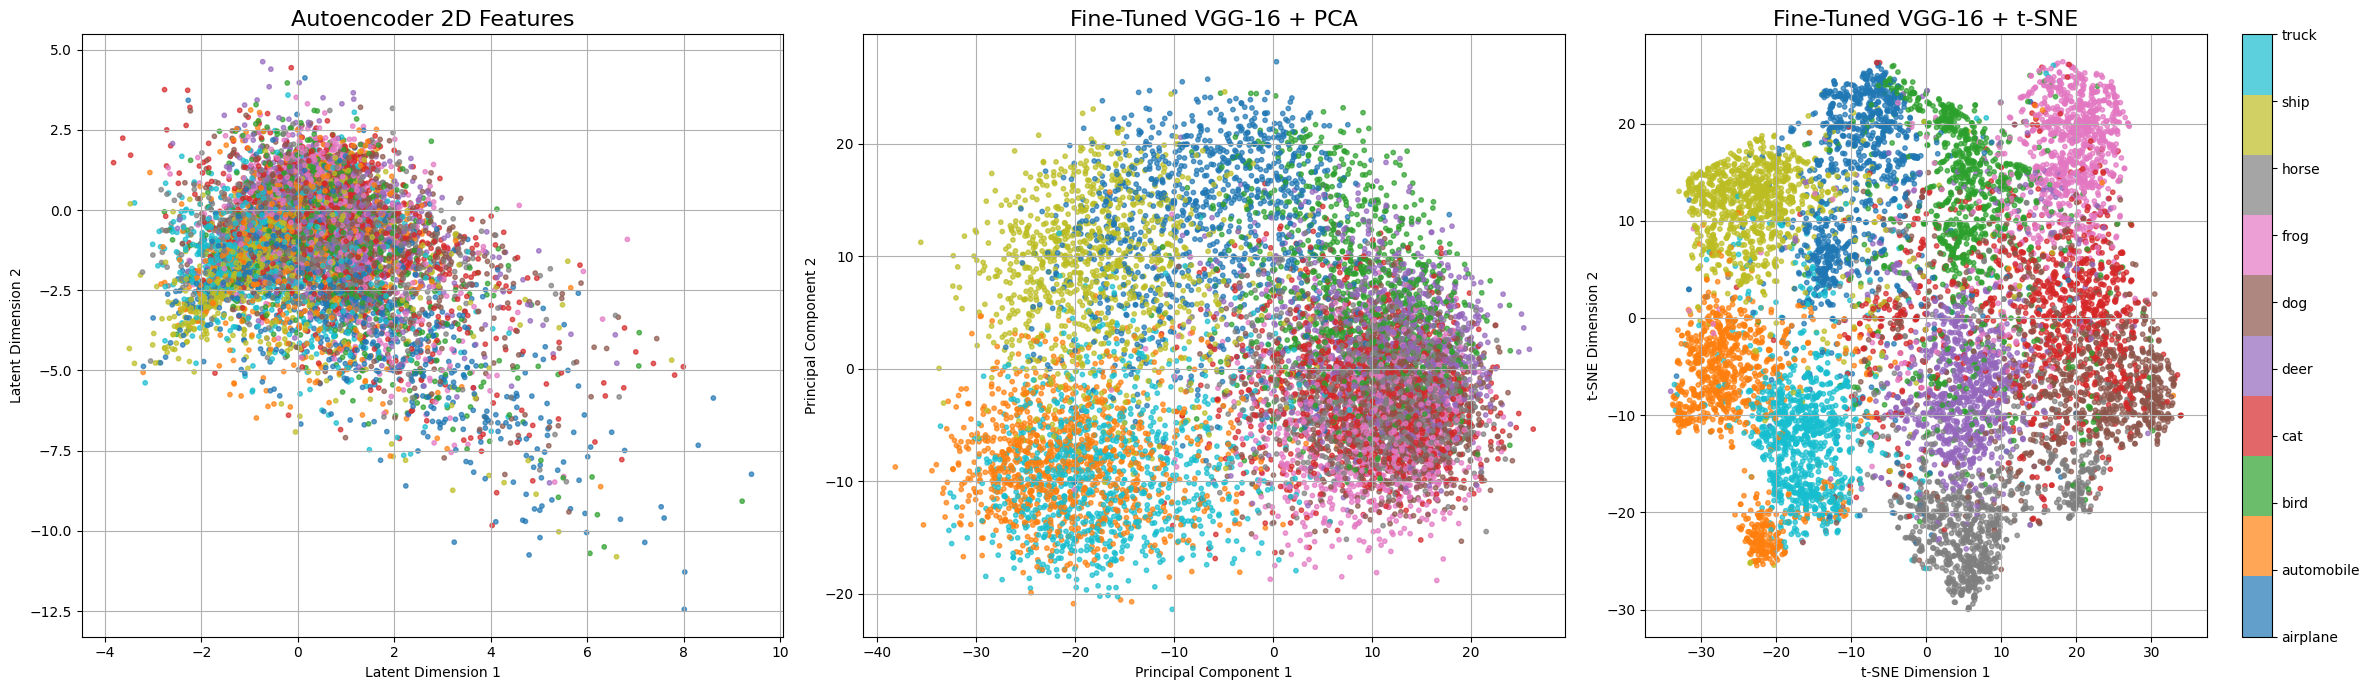

In [ ]:
plt.figure(figsize=(24, 7))

plt.subplot(1, 3, 1)
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Autoencoder 2D Features', fontsize=16)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(pca_features_tuned[:, 0], pca_features_tuned[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

ax3 = plt.subplot(1, 3, 3)
scatter = ax3.scatter(tsne_features_tuned[:, 0], tsne_features_tuned[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

cbar = plt.colorbar(scatter, ax=ax3, ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

# Task-3: Training a denoising autoencoder for CIFAR10 dataset.

# Adding Noise to the Images

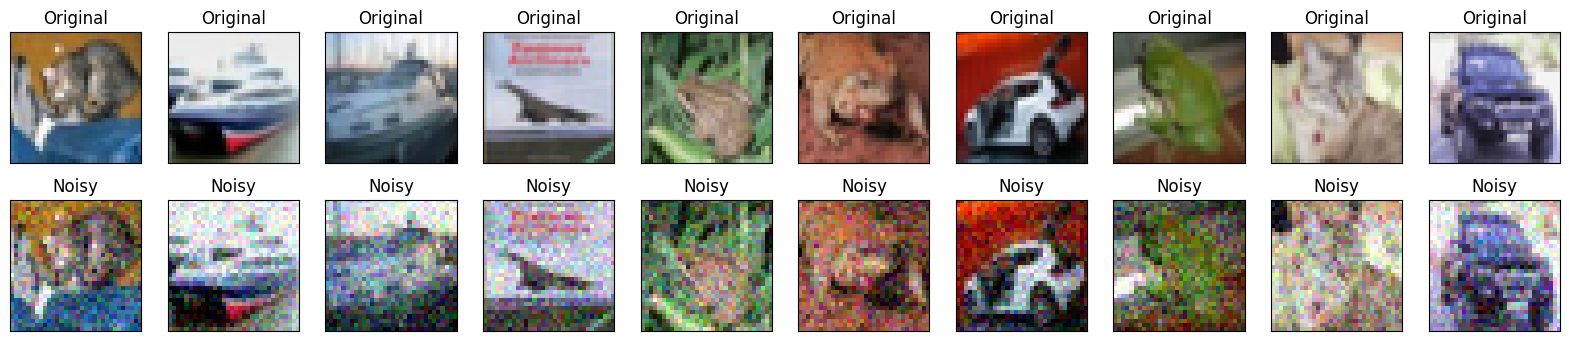

In [ ]:
noise_factor = 0.1

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Building the Denoising Autoencoder Model

In [ ]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 4x4 - This is the bottleneck

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 16x16
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 32x32
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,507 (584.01 KB)

 Trainable params: 149,507 (584.01 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train the denoising autoencoder

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

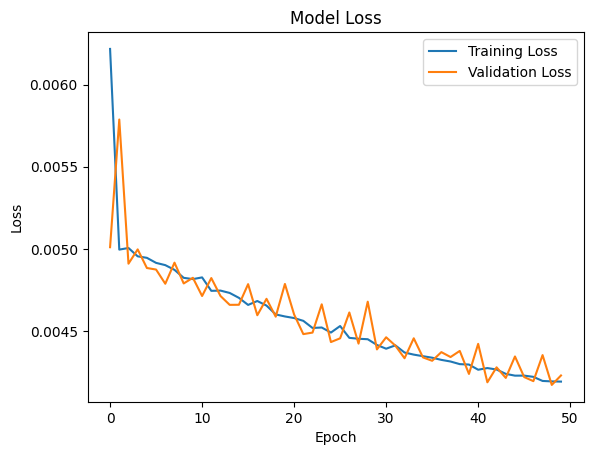

In [ ]:
denoising_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = denoising_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualize the denoised images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


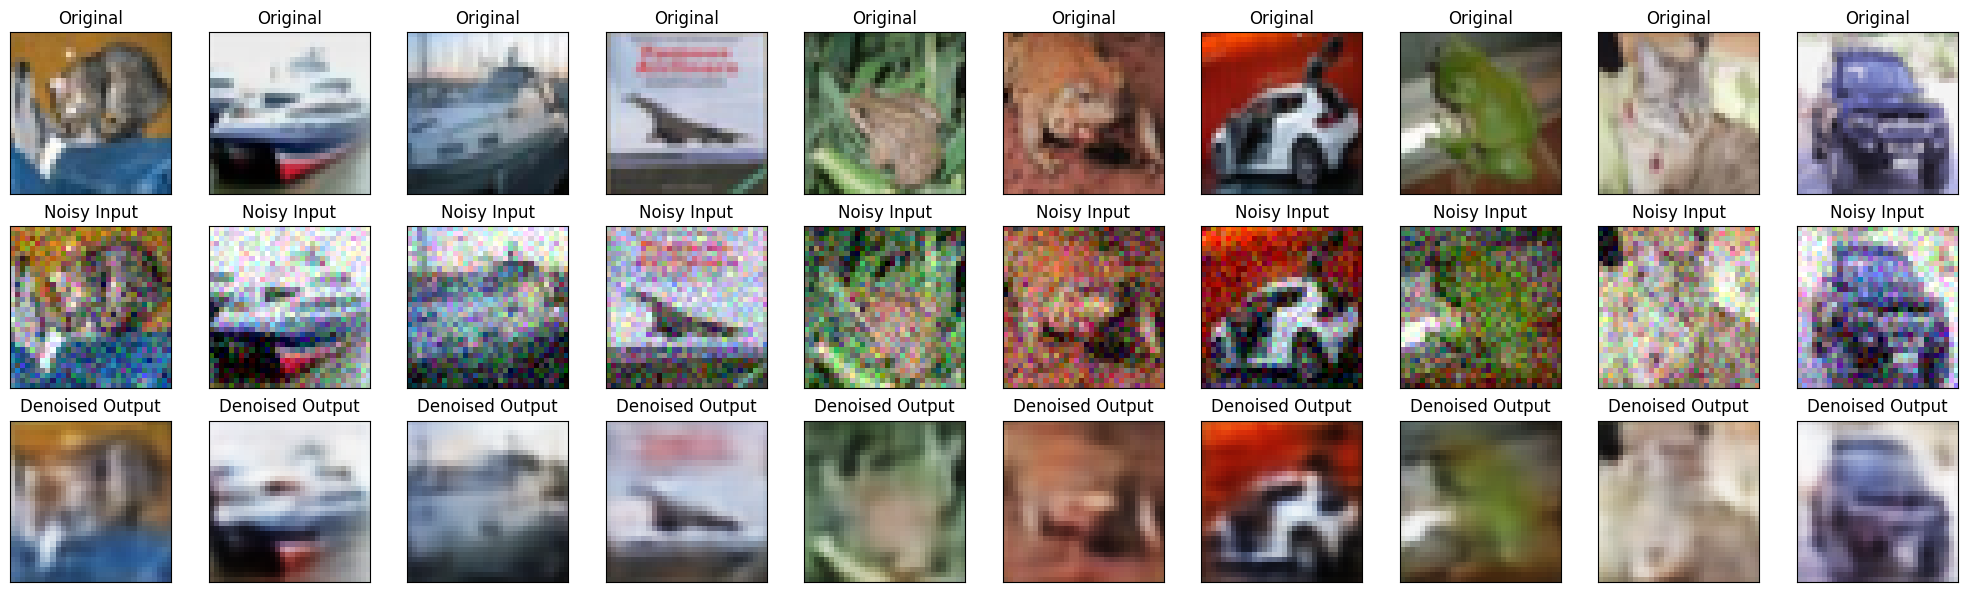

In [ ]:
denoised_images = denoising_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised Output")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Task-4: Training a CNN based CIFAR-10 classifier without any single-image data augmentation techniques.

# Build the VGG-16 based classifier

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

vgg_base.trainable = True
print(f"Number of layers in the base model: {len(vgg_base.layers)}")
print("All layers in the VGG16 base are now trainable.")

inputs = Input(shape=(32, 32, 3))
x = vgg_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(10)(x)

classifier_model = Model(inputs, outputs)

classifier_model.summary()

I0000 00:00:1752051523.119549 1204303 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Number of layers in the base model: 19
All layers in the VGG16 base are now trainable.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 14,848,586 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

# 

# Compile the model

In [ ]:
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


# 

# Imports and Constants

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import gc

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 40
IMAGE_SIZE = (32, 32, 3)
NUM_CLASSES = 10

# Data Preparation (Train / Validation / Test Split)

In [ ]:
(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()

x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, x_val, y_train, y_val = train_test_split(
    x_full_train, y_full_train, test_size=0.2, random_state=42
)

y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

print(f"Training set shape:   {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape:       {x_test.shape}")

Training set shape:   (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape:       (10000, 32, 32, 3)


# Create Data Pipelines

In [ ]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ],
    name="data_augmentation",
)

train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.shuffle(buffer_size=len(x_train))
train_ds_aug = train_ds_aug.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds_aug = train_ds_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds_no_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_no_aug = train_ds_no_aug.shuffle(buffer_size=len(x_train))
train_ds_no_aug = train_ds_no_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Data pipelines created.")

I0000 00:00:1752206329.381317 3166340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19743 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Data pipelines created.


# Visualize the augmented images

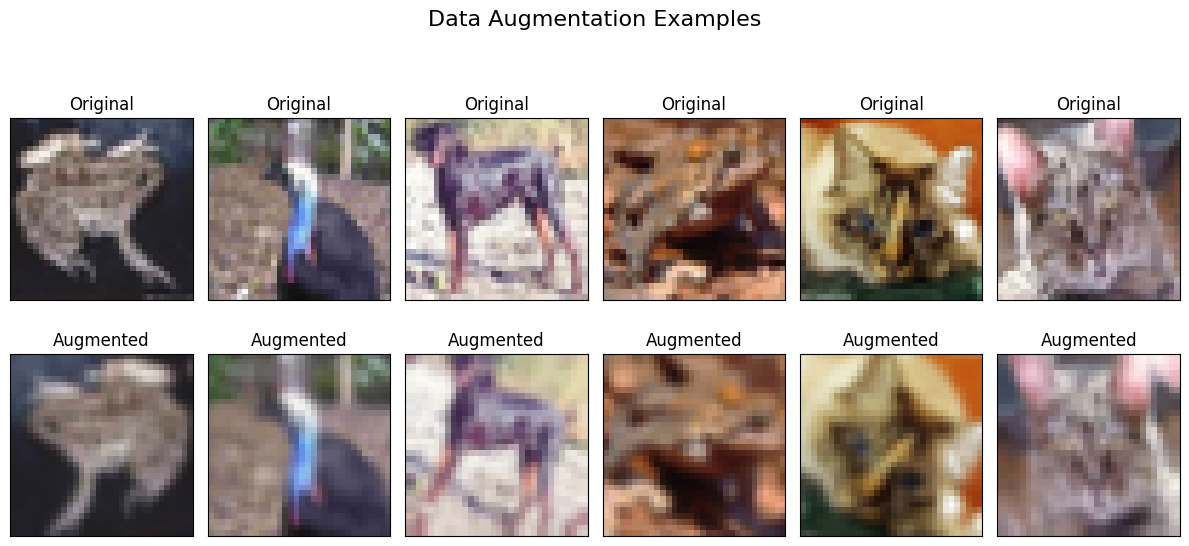

: 

In [ ]:

sample_images = x_train[:6]
augmented_images_list = []
for image in sample_images:
    augmented_image = data_augmentation(image)
    augmented_images_list.append(augmented_image)

augmented_images = np.array(augmented_images_list)

plt.figure(figsize=(12, 6))
plt.suptitle("Data Augmentation Examples", fontsize=16)

for i in range(6):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 6, i + 1 + 6)
    plt.imshow(np.clip(augmented_images[i], 0, 1))
    plt.title("Augmented")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Model Building Function

In [ ]:
def build_classifier_model():

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg_base.trainable = True

    inputs = Input(shape=(32, 32, 3))
    x = vgg_base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10)(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function defined.")

Model builder function defined.


# Train Model WITHOUT Augmentation

In [6]:
print("--- Training Model WITHOUT Data Augmentation ---")
model_no_aug = build_classifier_model()

history_no_aug = model_no_aug.fit(
    train_ds_no_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

--- Training Model WITHOUT Data Augmentation ---
Epoch 1/40


I0000 00:00:1752205151.001333 3139105 service.cc:152] XLA service 0x747abc003440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752205151.001355 3139105 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-11 09:39:11.043427: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752205151.325946 3139105 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-11 09:39:11.768617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 4 bytes spill stores, 4 bytes spill loads

2025-07-11 09:39:12.079832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 

 11/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1472 - loss: 2.3561

I0000 00:00:1752205154.611217 3139105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5022 - loss: 1.4127 - val_accuracy: 0.7353 - val_loss: 0.7611
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7561 - loss: 0.7041 - val_accuracy: 0.7744 - val_loss: 0.6574
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7974 - loss: 0.5873 - val_accuracy: 0.7908 - val_loss: 0.6057
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8259 - loss: 0.4940 - val_accuracy: 0.8008 - val_loss: 0.5867
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8516 - loss: 0.4247 - val_accuracy: 0.8150 - val_loss: 0.5407
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8760 - loss: 0.3584 - val_accuracy: 0.8147 - val_loss: 0.5509
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8929 - loss: 0.3086 - val_accuracy: 0.8193 - val_loss: 0.5438
Epoch 8/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9116 - loss: 0.2581 - val_accuracy: 0.81

# Task-5: Training a CNN based CIFAR-10 classifier with a single/multiple single-image data augmentation techniques.

# Train Model WITH Augmentation

In [7]:
print("\n--- Training Model WITH Data Augmentation ---")
model_with_aug = build_classifier_model()

history_with_aug = model_with_aug.fit(
    train_ds_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)


--- Training Model WITH Data Augmentation ---
Epoch 1/40


625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4283 - loss: 1.5930 - val_accuracy: 0.6357 - val_loss: 1.0185
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6769 - loss: 0.9255 - val_accuracy: 0.7415 - val_loss: 0.7514
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7203 - loss: 0.8000 - val_accuracy: 0.7385 - val_loss: 0.7638
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7442 - loss: 0.7361 - val_accuracy: 0.7518 - val_loss: 0.7046
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7573 - loss: 0.6922 - val_accuracy: 0.7770 - val_loss: 0.6343
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7735 - loss: 0.6470 - val_accuracy: 0.7828 - val_loss: 0.6400
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7866 - loss: 0.6058 - val_accuracy: 0.7985 - val_loss: 0.5778
Epoch 8/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7960 - loss: 0.5847 - val_accuracy: 0.79

# Final Evaluation and Visualization

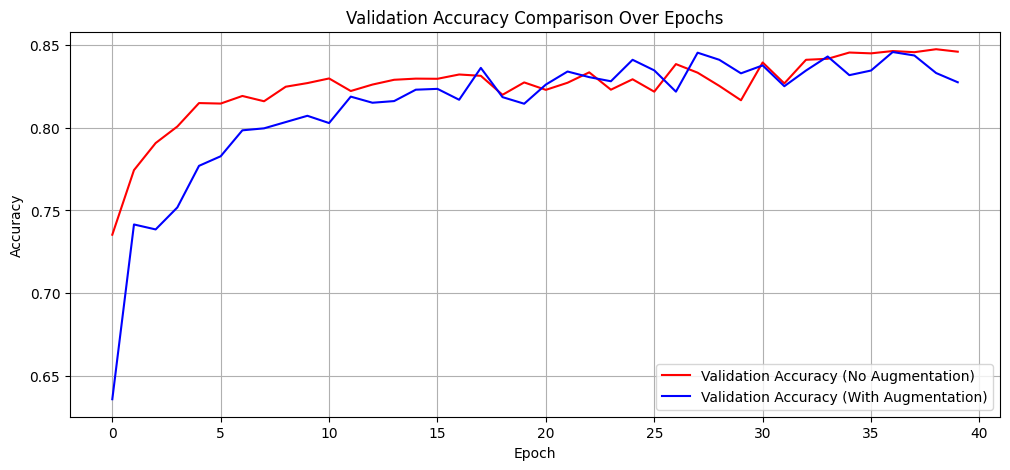


Evaluating final performance on the held-out test set...


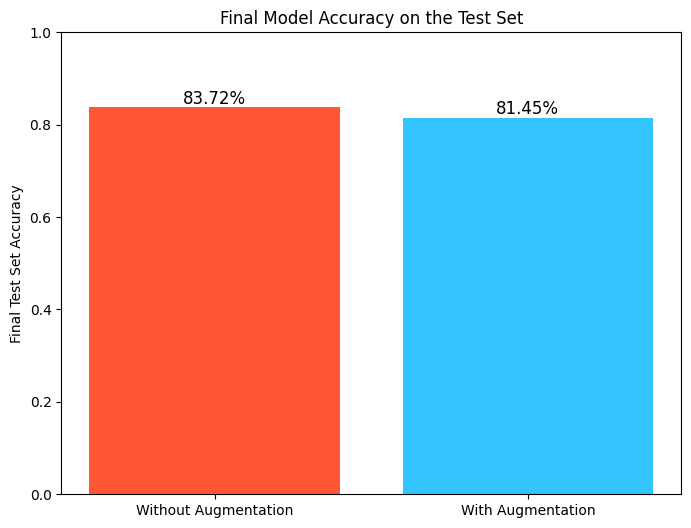

In [ ]:
val_acc_no_aug = history_no_aug.history['val_accuracy']
val_acc_with_aug = history_with_aug.history['val_accuracy']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.plot(epochs_range, val_acc_no_aug, label='Validation Accuracy (No Augmentation)', color='red')
plt.plot(epochs_range, val_acc_with_aug, label='Validation Accuracy (With Augmentation)', color='blue')
plt.title('Validation Accuracy Comparison Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nEvaluating final performance on the held-out test set...")
loss_no_aug, acc_no_aug = model_no_aug.evaluate(test_ds, verbose=0)
loss_with_aug, acc_with_aug = model_with_aug.evaluate(test_ds, verbose=0)

labels = ['Without Augmentation', 'With Augmentation']
test_accuracies = [acc_no_aug, acc_with_aug]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, test_accuracies, color=['#FF5733', '#33C4FF'])
plt.ylabel('Final Test Set Accuracy')
plt.title('Final Model Accuracy on the Test Set')
plt.ylim([0, 1.0])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=12)

plt.show()

# Build model with additional argument 'optimizer' to handel learning rate schedule

In [ ]:
def build_classifier_model(optimizer):

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg_base.trainable = True

    inputs = Input(shape=(32, 32, 3))
    x = vgg_base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10)(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function updated.")

Model builder function updated.


# Train the model with learning rate schedule

In [ ]:
print("\n--- Training Model WITH Augmentation and LR Scheduling ---")

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer_scheduled = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_aug_scheduled = build_classifier_model(optimizer_scheduled)

train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.shuffle(len(x_train)).map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

history_aug_scheduled = model_aug_scheduled.fit(
    train_ds_aug,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

print("\nEvaluating scheduled model on test set...")
_, acc_aug_scheduled = model_aug_scheduled.evaluate(test_ds, verbose=0)
print(f"Final Test Accuracy (With Augmentation + LR Schedule): {acc_aug_scheduled*100:.2f}%")


--- Training Model WITH Augmentation and LR Scheduling ---


Epoch 1/40


I0000 00:00:1752206353.873982 3167176 service.cc:152] XLA service 0x736f9002a450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752206353.874012 3167176 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-11 09:59:13.915440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752206354.194122 3167176 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-11 09:59:14.650481: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1037', 4 bytes spill stores, 4 bytes spill loads

2025-07-11 09:59:14.708779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1037', 

 14/625 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1663 - loss: 2.3113

I0000 00:00:1752206357.441862 3167176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5072 - loss: 1.3876 - val_accuracy: 0.7227 - val_loss: 0.8114
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7266 - loss: 0.7911 - val_accuracy: 0.7964 - val_loss: 0.5878
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7716 - loss: 0.6570 - val_accuracy: 0.8128 - val_loss: 0.5630
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8060 - loss: 0.5744 - val_accuracy: 0.8135 - val_loss: 0.5710
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8242 - loss: 0.5108 - val_accuracy: 0.8258 - val_loss: 0.5232
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8393 - loss: 0.4692 - val_accuracy: 0.8441 - val_loss: 0.4719
Epoch 7/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8542 - loss: 0.4240 - val_accuracy: 0.8364 - val_loss: 0.4991
Epoch 8/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8689 - loss: 0.3803 - val_accuracy: 0.85

# Plot all the results

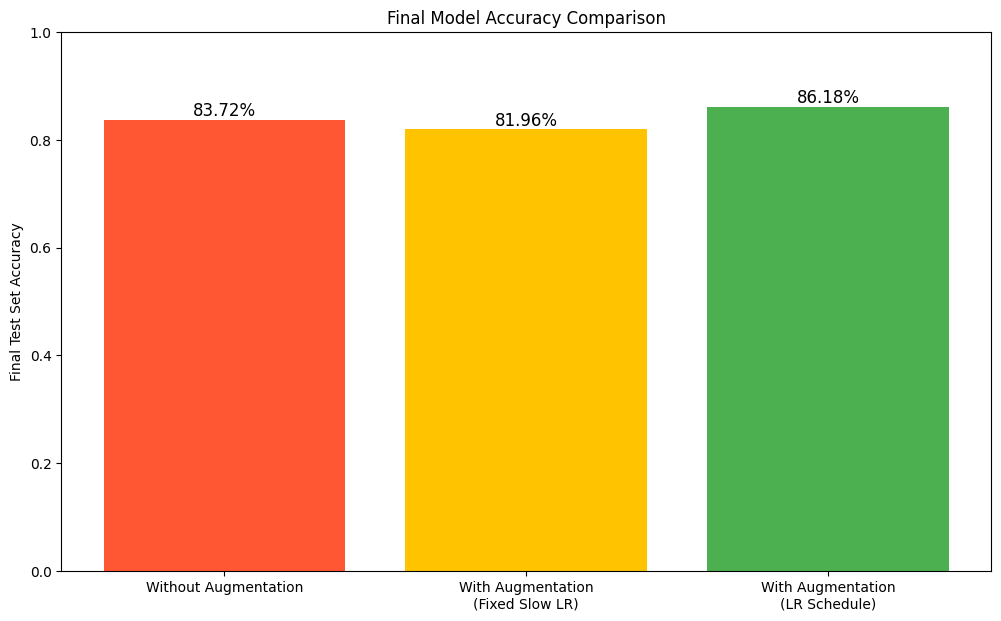

In [ ]:
acc_no_aug = 0.8372 

acc_with_aug_fixed_lr = 0.8196

acc_with_aug_scheduled = acc_aug_scheduled

labels = [
    'Without Augmentation', 
    'With Augmentation\n(Fixed Slow LR)', 
    'With Augmentation\n(LR Schedule)'
]
test_accuracies = [acc_no_aug, acc_with_aug_fixed_lr, acc_with_aug_scheduled]
colors = ['#FF5733', '#FFC300', '#4CAF50']

plt.figure(figsize=(12, 7))
bars = plt.bar(labels, test_accuracies, color=colors)

plt.ylabel('Final Test Set Accuracy')
plt.title('Final Model Accuracy Comparison')
plt.ylim([0, 1.0])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=12)

plt.show()